In [2]:
import sys
import os
sys.path.append("../")

import pandas as pd
import numpy as np
import pickle
from sklearn.cluster import KMeans
from sklearn.metrics import  silhouette_score, silhouette_samples
import matplotlib.pyplot as plt
from IPython.display import HTML
%matplotlib inline
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from scipy import stats

## Reading the change object and clustering.

In [3]:
article_name = "Truth"
change_object_dir =  "../data/change objects/"
change_vector_dir = "../data/change_vector/"

change_object_file_name = f"{article_name}_vec.npz"
filename =  f"{article_name}_change.h5"

change_object_file = os.path.join(change_object_dir, filename)
change_vector_file = os.path.join(change_vector_dir, change_object_file_name)

In [4]:
%%time
if os.path.exists(change_object_file):
    with pd.HDFStore(change_object_file, 'r') as store:
        change_object_dataframe = store.get("data")
else:
    print("file do not exist")

CPU times: user 940 ms, sys: 40.2 s, total: 41.2 s
Wall time: 41.6 s


In [5]:
change_object_dataframe.head()

ins_start_pos  \
from revision id to revision id timestamp           timegap          editor                            
286436           286907         2001-03-21 00:36:45 46 days 20:40:01 0|Larry_Sanger 0         4230.0   
                                                                                    1         4236.0   
                                                                                    2         4241.0   
                                                                                    3         4252.0   
                                                                                    4           -1.0   

                                                                                       ins_end_pos  \
from revision id to revision id timestamp           timegap          editor                          
286436           286907         2001-03-21 00:36:45 46 days 20:40:01 0|Larry_Sanger 0       4233.0   
                                                                                    1       4236.0   
                                                                                    2       4250.0   
                                                                                    3       4288.0   
                                                                                    4         -1.0   

                                                                                       left_neigh  \
from revision id to revision id timestamp           timegap          editor                         
286436           286907         2001-03-21 00:36:45 46 days 20:40:01 0|Larry_Sanger 0           2   
                                                                                    1           7   
                                                                                    2           9   
                                                                                    3        4242   
                                                                                    4           2   

                                                                                       right_neigh  \
from revision id to revision id timestamp           timegap          editor                          
286436           286907         2001-03-21 00:36:45 46 days 20:40:01 0|Larry_Sanger 0            1   
                                                                                    1            4   
                                                                                    2            9   
                                                                                    3           13   
                                                                                    4            4   

                                                                                       del_start_pos  \
from revision id to revision id timestamp           timegap          editor                            
286436           286907         2001-03-21 00:36:45 46 days 20:40:01 0|Larry_Sanger 0           -1.0   
                                                                                    1           -1.0   
                                                                                    2           -1.0   
                                                                                    3           -1.0   
                                                                                    4            3.0   

                                                                                       del_end_pos  \
from revision id to revision id timestamp           timegap          editor                          
286436           286907         2001-03-21 00:36:45 46 days 20:40:01 0|Larry_Sanger 0         -1.0   
                                                                                    1         -1.0   
                                                                                   

## Read Vectors of change object.

In [6]:
with open(change_vector_file, "rb") as file:
    arrays_dict = np.load(file)
    neighbour_10_matrix = arrays_dict["neighbour_10"]
    ins_del_10_sum_neighbour_matrix = arrays_dict["ins_del_10_sum_neighbour"]
    neighbour_4_matrix = arrays_dict["neighbour_4"]
    ins_del_4_sum_neighbour_matrix = arrays_dict["ins_del_4_sum_neighbour"]
    weighted_neighbour_matrix_matrix = arrays_dict["weighted_neighbour_matrix"]
    ins_del_weighted_neighbour_matrix = arrays_dict["ins_del_weighted_neighbour_matrix"]

### Make left, ins and delete string for visualisation

In [7]:
change_object_dataframe["left_string"] = change_object_dataframe["left_token"].str.join(" ")
change_object_dataframe["ins_string"] = change_object_dataframe["ins_tokens"].str.join(" ")
change_object_dataframe["del_string"] = change_object_dataframe["del_tokens"].str.join(" ")
change_object_dataframe["right_string"] = change_object_dataframe["right_token"].str.join(" ")

In [8]:
change_object_dataframe["ins_token_len"]=change_object_dataframe["ins_tokens"].str.len()
change_object_dataframe["del_token_len"]=change_object_dataframe["del_tokens"].str.len()

## Clustering

In [9]:
table_style =     [
    {'selector': 'table', 'props': [('border', "6px double #696969")]},
    {'selector': 'th', 'props': [('border', "2px solid #D3D3D3"), ("font-size", "100%")]},
    {"selector":".data", "props":[("text-align", "justify"), ('border', "1px solid #000"), ('margin', '4px 24px 4px 24px' ), ("font-size", "8pt")]}
] 

deleted_token_style = {"color":"red", "font-weight": "bold","font-size": "100px"}
inserted_token_style = {"color":"blue", "font-weight": "bold","font-size": "100px"}

In [10]:
style_dict = {'border': "2px solid #000",
              "text-align": "justify"
    
}

In [11]:
%%time
NO_OF_CLUSTERS = 70
km = KMeans(n_clusters= NO_OF_CLUSTERS, n_jobs=3)
clusters_4 = km.fit(neighbour_4_matrix)

CPU times: user 4min 34s, sys: 47.6 s, total: 5min 22s
Wall time: 1min 35s


In [12]:
change_object_dataframe["cluster_4"] = pd.Series(clusters_4.labels_, index= change_object_dataframe.index)
change_grouped_by_tokens_4_neigh = change_object_dataframe.groupby("cluster_4")

In [13]:
repers_4_neigh = change_grouped_by_tokens_4_neigh[["left_string", "del_string", "ins_string", "right_string"]].apply(lambda x: x.style.render())

In [14]:
@interact( clusters_html=fixed(repers_4_neigh), group=range(change_grouped_by_tokens_4_neigh.ngroups))
def display_clusters(clusters_html, group):
     return display(HTML(clusters_html.iloc[group]))

interactive(children=(Dropdown(description='group', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14,…

##### Cluster number of neighbour tokens=10, number of clusters =100 

In [15]:
%%time
NO_OF_CLUSTERS = 100
km = KMeans(n_clusters= NO_OF_CLUSTERS, n_jobs=3)
clusters_10 = km.fit(neighbour_10_matrix)

CPU times: user 5min 40s, sys: 34.4 s, total: 6min 15s
Wall time: 1min 55s


In [16]:
change_object_dataframe["cluster_10"] = pd.Series(clusters_10.labels_, index= change_object_dataframe.index)
change_grouped_by_tokens_10_neigh = change_object_dataframe.groupby("cluster_10")

In [17]:
repers_10_full_neigh = change_grouped_by_tokens_10_neigh[["left_string", "del_string", "ins_string", "right_string"]].apply(lambda x: x.style.render())

In [18]:
@interact( clusters_html=fixed(repers_10_full_neigh), group=range(change_grouped_by_tokens_10_neigh.ngroups))
def display_clusters(clusters_html, group):
     return display(HTML(clusters_html.iloc[group]))

interactive(children=(Dropdown(description='group', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14,…

### Clustering with vectors concatinated vectors average of 4 right and left neighbours and average of inserted and deleted tokens. 

In [19]:
%%time
NO_OF_CLUSTERS = 100
km = KMeans(n_clusters= NO_OF_CLUSTERS, n_jobs=3)
clusters_4_full = km.fit(ins_del_4_sum_neighbour_matrix)
change_object_dataframe["cluster_4_full"] = pd.Series(clusters_4_full.labels_, index= change_object_dataframe.index)

CPU times: user 8min 2s, sys: 58.6 s, total: 9min 1s
Wall time: 3min


In [20]:
change_grouped_by_tokens_4_full = change_object_dataframe.groupby("cluster_4_full")

In [21]:
repers_4_full_neigh = change_grouped_by_tokens_4_full[["left_string", "del_string", "ins_string", "right_string"]].apply(lambda x: x.style.render())

In [22]:
@interact( clusters_html=fixed(repers_4_full_neigh), group=range(change_grouped_by_tokens_4_full.ngroups))
def display_clusters(clusters_html, group):
     return display(HTML(clusters_html.iloc[group]))

interactive(children=(Dropdown(description='group', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14,…

### Clustering with vectors concatinated vectors weighted average of 4 right and left neighbours and average of inserted and deleted tokens. 

In [23]:
%%time
NO_OF_CLUSTERS = 100
km = KMeans(n_clusters= NO_OF_CLUSTERS, n_jobs=3)
clusters_4_full = km.fit(ins_del_weighted_neighbour_matrix)
change_object_dataframe["cluster_4_weighted"] = pd.Series(clusters_4_full.labels_, index= change_object_dataframe.index)

CPU times: user 7min 54s, sys: 41.1 s, total: 8min 35s
Wall time: 2min 51s


In [24]:
change_grouped_by_tokens_4_weighted = change_object_dataframe.groupby("cluster_4_weighted")

In [25]:
repers_4_weighted = change_grouped_by_tokens_4_weighted[["left_string", "del_string", "ins_string", "right_string"]].apply(lambda x: x.style.render())

In [26]:
@interact( clusters_html=fixed(repers_4_weighted), group=range(change_grouped_by_tokens_4_weighted.ngroups))
def display_clusters(clusters_html, group):
     return display(HTML(clusters_html.iloc[group]))

interactive(children=(Dropdown(description='group', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14,…

### Saving the cluster with change object
###### TO-DO: save change object and cluster seperately.

In [34]:
cluster_dir = "../data/clusters/"
file_name = article_name + "_cluster.h5"
full_file_path = os.path.join(cluster_dir, file_name)
with pd.HDFStore(full_file_path, 'w') as store:
    store.put("cluster", change_object_dataframe[['cluster_4', 'cluster_10',
       'cluster_4_full', 'cluster_4_weighted']], table=False)

### Ranking
###### Ranking clustered groups on following parameters.
1. Size of clusters
2. No of unique editors is clusters
3. Total period of cluster. i.e difference between start and end date.
4. Median length of edited token in each cluster.

In [28]:
rank_by_size = change_grouped_by_tokens_4_weighted.size().sort_values(ascending=False)

In [29]:
rank_by_uniq_editor = change_object_dataframe.reset_index().groupby("cluster_4_weighted")["editor"].nunique().sort_values(ascending=False)

In [30]:
rank_by_period = change_object_dataframe.reset_index().groupby("cluster_4_weighted")["timestamp"].apply(lambda x: x.max() - x.min()).sort_values(ascending=False)

In [31]:
rank_by_rate = change_object_dataframe.reset_index().groupby("cluster_4_weighted")["timegap"].apply(lambda x: x.mean()).sort_values(ascending=False)

In [32]:
rank_by_token_length = (change_grouped_by_tokens_4_weighted["ins_token_len"].median() + change_grouped_by_tokens_4_weighted["del_token_len"].median()).sort_values()
rank_by_token_length = rank_by_token_length /2

In [33]:
ins_tokens_per_group = change_grouped_by_tokens_4_weighted["ins_tokens"].apply(lambda x: pd.Series(np.concatenate(x.values,axis=0)))
ins_tokens_per_group = change_grouped_by_tokens_4_weighted["del_tokens"].apply(lambda x: pd.Series(np.concatenate(x.values,axis=0)))

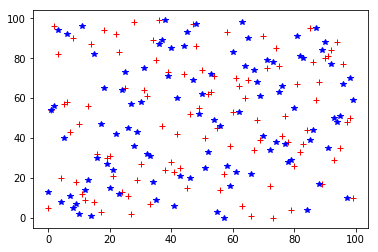

In [98]:
plt.plot(rank_by_period.index, "r+")
plt.plot( rank_by_uniq_editor.index, "b*")
# plt.scatter(np.log10(rank_by_size), rank_by_token_length)
# plt.scatter(np.log10(rank_by_size), np.log10(pd.to_numeric(rank_by_period)))
# plt.scatter(np.log10(rank_by_size), np.log10(pd.to_numeric(rank_by_rate)))

In [ ]:
change_grouped_by_tokens.get_group(cluster_ranks_by_period.index.tolist()[0])

In [ ]:
change_grouped_by_tokens.get_group(cluster_ranks_by_period.index.tolist()[0])["del_string"].str.cat()

In [ ]:
%%time
silhoutee_s = []
for n in range(2,48,2):
    km = KMeans(n_clusters= n, n_jobs=3)
    clusters = km.fit(ins_del_sum_neighbour_matrix)
    cluster_s = pd.Series(clusters.labels_, index= change_df.index)
    silhoutee_s.append(silhouette_score(change_matrix, cluster_s))

In [ ]:
x = np.arange(2,48,2)
plt.plot(x,silhoutee_s)

In [ ]:
x[np.argsort(silhoutee_s)[-8:]]

In [ ]:
np.array(silhoutee_s)[np.argsort(silhoutee_s)[-8:]]

In [ ]:
%%time
km = KMeans(n_clusters= 12, n_jobs=3)
clusters = km.fit(ins_del_sum_neighbour_matrix)
cluster_s = pd.Series(clusters.labels_, index= change_df.index)
change_df["cluster"] = cluster_s
change_grouped_by_sum = change_df.groupby("cluster")
change_grouped_by_sum.size().plot()

In [ ]:
rank_by_size = change_grouped_by_sum.size().sort_values()
rank_by_size

In [ ]:
rank_by_uniq_editor = change_grouped_by_sum["editor_s"].nunique().sort_values()

In [ ]:
rank_by_period = change_grouped_by_sum["timestamp"].apply(lambda x: x.max() - x.min()).sort_values()

In [ ]:
rank_by_rate = change_grouped_by_sum["time_gap"].apply(lambda x: x.mean()).sort_values()

In [ ]:
rank_by_token_length = (change_grouped_by_sum["ins_token_len"].median() + change_grouped_by_sum["del_token_len"].median()).sort_values()
rank_by_token_length = ranks_by_token_length /2

In [ ]:
plt.scatter(np.log10(cluster_ranks_by_size), rank_by_uniq_editor)
plt.scatter(np.log10(cluster_ranks_by_size), rank_by_token_length)
plt.scatter(np.log10(cluster_ranks_by_size), np.log10(pd.to_numeric(rank_by_period)))
plt.scatter(np.log10(cluster_ranks_by_size), np.log10(pd.to_numeric(rank_by_rate)))

In [ ]:
change_grouped_by_sum.get_group(9)[["del_string", "ins_string"]]